<a href="https://colab.research.google.com/github/AmyHumke12/SolarProject/blob/main/IPTV_SolarProduction_Pre_Processing_Step_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocessing Step 2
This notebook seeks to pre-process the data and do a train test split.

In [ ]:
!pip install xgboost hyperopt

SyntaxError: invalid syntax (4035839222.py, line 1)

In [5]:
#Requirements
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import pickle
import io
import requests
from itertools import combinations
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import KFold


# Ensure inline plotting in Jupyter notebooks or Google Colab
%matplotlib inline


##Load Data

In [6]:
# Define GitHub raw file URLs
github_base_url = "https://raw.githubusercontent.com/AmyHumke12/SolarProject/main/"

files = {
    "production_df": "iptv_solaredge_data_cleaned.pkl",
    "weather_df": "iptv_weather_data_final.pkl",
    "electric_df": "iptv_electric_data_cleaned.pkl",
    "df_solar": "solar_production_estimate.pkl"
}

# Function to load pickle files from GitHub
def load_pickle_from_github(filename):
    url = github_base_url + filename
    response = requests.get(url)
    
    if response.status_code == 200:
        return pickle.load(io.BytesIO(response.content))
    else:
        raise Exception(f"❌ Failed to load {filename}. HTTP Status: {response.status_code}")

# Load data from GitHub
production_df = load_pickle_from_github(files["production_df"])
weather_df = load_pickle_from_github(files["weather_df"])
electric_df = load_pickle_from_github(files["electric_df"])
df_solar = load_pickle_from_github(files["df_solar"])

# Verify data loads correctly
print("✅ Data loaded successfully!")
print(production_df.head(), weather_df.head(), electric_df.head(), df_solar.head())


✅ Data loaded successfully!
                 date   meter_type  value           date_meter_combination  \
0 2024-01-01 00:00:00  Consumption    NaN  2024-01-01 00:00:00_Consumption   
1 2024-01-01 01:00:00  Consumption    NaN  2024-01-01 01:00:00_Consumption   
2 2024-01-01 02:00:00  Consumption    NaN  2024-01-01 02:00:00_Consumption   
3 2024-01-01 03:00:00  Consumption    NaN  2024-01-01 03:00:00_Consumption   
4 2024-01-01 04:00:00  Consumption    NaN  2024-01-01 04:00:00_Consumption   

   hour  
0     0  
1     1  
2     2  
3     3  
4     4                  date_x  temperature_2m  relative_humidity_2m  dew_point_2m  \
0 2022-01-01 00:00:00       29.179399             92.888649     27.379400   
1 2022-01-01 01:00:00       29.629400             93.591866     28.009399   
2 2022-01-01 02:00:00       29.449400             93.586723     27.829399   
3 2022-01-01 03:00:00       28.729401             94.262344     27.289400   
4 2022-01-01 04:00:00       24.229401             97.03324

In [7]:
filtered_df = production_df[(production_df['date'].dt.date == pd.to_datetime('2024-07-15').date()) &
                            (production_df['meter_type'] == 'Production')]
filtered_df

,date,meter_type,value,date_meter_combination,hour
17808,2024-07-15 00:00:00,Production,0.000,2024-07-15 00:00:00_Production,0
17809,2024-07-15 01:00:00,Production,0.000,2024-07-15 01:00:00_Production,1
17810,2024-07-15 02:00:00,Production,0.000,2024-07-15 02:00:00_Production,2
17811,2024-07-15 03:00:00,Production,0.000,2024-07-15 03:00:00_Production,3
17812,2024-07-15 04:00:00,Production,0.000,2024-07-15 04:00:00_Production,4
17813,2024-07-15 05:00:00,Production,0.021,2024-07-15 05:00:00_Production,5
17814,2024-07-15 06:00:00,Production,1.728,2024-07-15 06:00:00_Production,6
17815,2024-07-15 07:00:00,Production,3.812,2024-07-15 07:00:00_Production,7
17816,2024-07-15 08:00:00,Production,8.863,2024-07-15 08:00:00_Production,8
17817,2024-07-15 09:00:00,Production,11.088,2024-07-15 09:00:00_Production,9


In [8]:

# Ensure that the date column is in datetime format
production_df['date'] = pd.to_datetime(production_df['date'])

# Filter the DataFrame for the specific date '2024-07-15'
filtered_production_df = production_df[production_df['date'].dt.strftime('%Y-%m-%d') == '2024-07-15']

# Display the filtered DataFrame
filtered_production_df

,date,meter_type,value,date_meter_combination,hour
17808,2024-07-15 00:00:00,Production,0.000,2024-07-15 00:00:00_Production,0
17809,2024-07-15 01:00:00,Production,0.000,2024-07-15 01:00:00_Production,1
17810,2024-07-15 02:00:00,Production,0.000,2024-07-15 02:00:00_Production,2
17811,2024-07-15 03:00:00,Production,0.000,2024-07-15 03:00:00_Production,3
17812,2024-07-15 04:00:00,Production,0.000,2024-07-15 04:00:00_Production,4
...,...,...,...,...,...
20059,2024-07-15 19:00:00,Consumption,4.255,2024-07-15 19:00:00_Consumption,19
20060,2024-07-15 20:00:00,Consumption,3.044,2024-07-15 20:00:00_Consumption,20
20061,2024-07-15 21:00:00,Consumption,2.083,2024-07-15 21:00:00_Consumption,21
20062,2024-07-15 22:00:00,Consumption,2.662,2024-07-15 22:00:00_Consumption,22


In [9]:
weather_df

,date_x,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,...,global_tilted_irradiance,hour,is_daylight,solar_angle,solar_azimuth,sunrise_hour,sunset_hour,sunset,sunrise,date_timestamp
0,2022-01-01 00:00:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,97.0,97.0,0.0,...,0.0,0,0,-70.688555,3.056930,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 00:00:00
1,2022-01-01 01:00:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,99.0,99.0,0.0,...,0.0,1,0,-66.512771,39.814783,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 01:00:00
2,2022-01-01 02:00:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,100.0,100.0,0.0,...,0.0,2,0,-57.778016,63.069547,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 02:00:00
3,2022-01-01 03:00:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,79.0,79.0,0.0,...,0.0,3,0,-47.315025,78.020430,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 03:00:00
4,2022-01-01 04:00:00,24.229401,97.033241,23.509399,0.0,0.0,0.131234,99.0,99.0,0.0,...,0.0,4,0,-36.299107,89.240580,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27331,2025-02-12 19:00:00,19.639400,60.584114,8.209400,0.0,0.0,NaN,100.0,56.0,99.0,...,0.0,19,0,-18.770509,268.864556,6,17,2025-02-12 17:20:58.582971-06:00,2025-02-12 06:52:20.688947-06:00,2025-02-12 19:00:00
27332,2025-02-12 20:00:00,20.179399,60.907997,8.839401,0.0,0.0,NaN,100.0,66.0,100.0,...,0.0,20,0,-29.822438,279.360892,6,17,2025-02-12 17:20:58.582971-06:00,2025-02-12 06:52:20.688947-06:00,2025-02-12 20:00:00
27333,2025-02-12 21:00:00,19.999399,62.628445,9.289402,0.0,0.0,NaN,100.0,88.0,100.0,...,0.0,21,0,-40.501070,291.588175,6,17,2025-02-12 17:20:58.582971-06:00,2025-02-12 06:52:20.688947-06:00,2025-02-12 21:00:00
27334,2025-02-12 22:00:00,20.089399,63.147968,9.559399,0.0,0.0,NaN,100.0,84.0,100.0,...,0.0,22,0,-50.164176,307.253967,6,17,2025-02-12 17:20:58.582971-06:00,2025-02-12 06:52:20.688947-06:00,2025-02-12 22:00:00


In [10]:
# Filter the DataFrame to exclude rows where 'temperature_2m' is NaN
filtered_weather_df = weather_df[weather_df['temperature_2m'].notna()]

# Find the maximum date in the filtered DataFrame
max_date = filtered_weather_df['date_x'].max()

# Print the maximum date
print(f"The maximum date where 'temperature_2m' is not NaN: {max_date}")


The maximum date where 'temperature_2m' is not NaN: 2025-02-12 23:00:00


##Identify the timeframe where there is solar production data

In [11]:
# Filter the DataFrame where meter_type is 'Production' and value is not NaN
production_data = production_df[(production_df['meter_type'] == 'Production') & (production_df['value'].notna())]

# Extract the unique dates where production data is available
available_production_dates = production_data['date'].unique()

# Print the unique dates where production data is available
print("Dates with Production Data:")
print(available_production_dates)


Dates with Production Data:
<DatetimeArray>
['2024-01-08 09:00:00', '2024-01-08 10:00:00', '2024-01-08 11:00:00',
 '2024-01-08 12:00:00', '2024-01-08 13:00:00', '2024-01-08 14:00:00',
 '2024-01-08 15:00:00', '2024-01-08 16:00:00', '2024-01-08 17:00:00',
 '2024-01-08 18:00:00',
 ...
 '2025-02-16 14:00:00', '2025-02-16 15:00:00', '2025-02-16 16:00:00',
 '2025-02-16 17:00:00', '2025-02-16 18:00:00', '2025-02-16 19:00:00',
 '2025-02-16 20:00:00', '2025-02-16 21:00:00', '2025-02-16 22:00:00',
 '2025-02-16 23:00:00']
Length: 9734, dtype: datetime64[ns]


#Identify the weather dates

In [12]:
min_date = weather_df['date_x'].min()
max_date = weather_df['date_x'].max()

print(f"Minimum date_x value: {min_date}")
print(f"Maximum date_x value: {max_date}")

Minimum date_x value: 2022-01-01 00:00:00
Maximum date_x value: 2025-02-12 23:00:00


##Filter Production to include the dates where there is production and weather data

In [13]:
# Ensure the 'date' column in production_df is in datetime format
production_df['date'] = pd.to_datetime(production_df['date'])

# Define the specific date range (end_date at the last moment of 8/21/2024)
start_date = pd.to_datetime('2024-01-09')
end_date = pd.to_datetime('2024-09-09 23:59:59') #Weather data is the limiting point

# Filter production_df within the specific date range and where meter_type is "Production"
filtered_production_df = production_df[
    (production_df['date'] >= start_date) &
    (production_df['date'] <= end_date) &
    (production_df['meter_type'] == "Production")
]


In [14]:
filtered_production_df

,date,meter_type,value,date_meter_combination,hour
2424,2024-01-09 00:00:00,Production,0.000,2024-01-09 00:00:00_Production,0
2425,2024-01-09 01:00:00,Production,0.000,2024-01-09 01:00:00_Production,1
2426,2024-01-09 02:00:00,Production,0.000,2024-01-09 02:00:00_Production,2
2427,2024-01-09 03:00:00,Production,0.000,2024-01-09 03:00:00_Production,3
2428,2024-01-09 04:00:00,Production,0.000,2024-01-09 04:00:00_Production,4
...,...,...,...,...,...
25795,2024-09-09 19:00:00,Production,0.001,2024-09-09 19:00:00_Production,19
25796,2024-09-09 20:00:00,Production,0.000,2024-09-09 20:00:00_Production,20
25797,2024-09-09 21:00:00,Production,0.000,2024-09-09 21:00:00_Production,21
25798,2024-09-09 22:00:00,Production,0.000,2024-09-09 22:00:00_Production,22


##Filter the weather to include the dates where there is production and weather data

In [15]:

# Ensure the 'date_x' column in weather_df is in datetime format
weather_df['date_x'] = pd.to_datetime(weather_df['date_x'])

# Define the specific date range (end_date at the last moment of 8/21/2025)
start_date = pd.to_datetime('2024-01-09')
end_date = pd.to_datetime('2024-09-09 23:59:59')

# Filter weather_df within the specific date range
filtered_weather_df = weather_df[
    (weather_df['date_x'] >= start_date) &
    (weather_df['date_x'] <= end_date)
]



##Join the weather and the production data

In [16]:
# Ensure the 'date' and 'date_x' columns are in datetime format
filtered_production_df.loc[:, 'date'] = pd.to_datetime(filtered_production_df['date'])
filtered_weather_df.loc[:, 'date_x'] = pd.to_datetime(filtered_weather_df['date_x'])

# Perform the left join
merged_df = pd.merge(filtered_production_df, filtered_weather_df, left_on='date', right_on='date_x', how='left')

# Display the structure and a sample of the merged DataFrame to verify the result
print(merged_df.info())
print(merged_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype                          
---  ------                    --------------  -----                          
 0   date                      5880 non-null   datetime64[ns]                 
 1   meter_type                5880 non-null   object                         
 2   value                     5879 non-null   float64                        
 3   date_meter_combination    5880 non-null   object                         
 4   hour_x                    5880 non-null   int32                          
 5   date_x                    5880 non-null   datetime64[ns]                 
 6   temperature_2m            5880 non-null   float32                        
 7   relative_humidity_2m      5880 non-null   float32                        
 8   dew_point_2m              5880 non-null   float32                        
 9   precipitation      

In [17]:
# Find and display the row(s) with any null values
null_rows = merged_df[merged_df.isnull().any(axis=1)]

# Display the row with null values
print(null_rows)

#There is 1 NaN production value and that is happening when it is not daytime so that is ok since the analysis will be focused on day.
#There are NaN snow data. Those can be 0 filled because they happen in summer dates.

                    date  meter_type   value          date_meter_combination  \
1466 2024-03-10 02:00:00  Production     NaN  2024-03-10 02:00:00_Production   
4601 2024-07-18 17:00:00  Production   1.358  2024-07-18 17:00:00_Production   
4602 2024-07-18 18:00:00  Production   0.528  2024-07-18 18:00:00_Production   
4603 2024-07-18 19:00:00  Production   0.283  2024-07-18 19:00:00_Production   
4604 2024-07-18 20:00:00  Production   0.016  2024-07-18 20:00:00_Production   
...                  ...         ...     ...                             ...   
5076 2024-08-07 12:00:00  Production  11.567  2024-08-07 12:00:00_Production   
5077 2024-08-07 13:00:00  Production  10.206  2024-08-07 13:00:00_Production   
5078 2024-08-07 14:00:00  Production   8.149  2024-08-07 14:00:00_Production   
5079 2024-08-07 15:00:00  Production   5.227  2024-08-07 15:00:00_Production   
5080 2024-08-07 16:00:00  Production   2.365  2024-08-07 16:00:00_Production   

      hour_x              date_x  tempe

In [18]:
# Replace NaN values in 'snow_depth' with 0 only for months between May (5) and October (10) inclusive
merged_df.loc[(merged_df['snow_depth'].isna()) & (merged_df['date_x'].dt.month >= 5) & (merged_df['date_x'].dt.month <= 10), 'snow_depth'] = 0


# Fill NaN values in 'value' with 0 where 'is_daylight' is 0
merged_df.loc[(merged_df['is_daylight'] == 0) & (merged_df['value'].isnull()), 'value'] = 0

#Add month and day number fields.
# Ensure the 'date' column is in datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Add a column for the day of the month
merged_df['day_of_month'] = merged_df['date'].dt.day

# Add a column for the month
merged_df['month'] = merged_df['date'].dt.month

# Display the first few rows to verify
merged_df

,date,meter_type,value,date_meter_combination,hour_x,date_x,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,...,is_daylight,solar_angle,solar_azimuth,sunrise_hour,sunset_hour,sunset,sunrise,date_timestamp,day_of_month,month
0,2024-01-09 00:00:00,Production,0.000,2024-01-09 00:00:00_Production,0,2024-01-09 00:00:00,24.949400,89.307854,22.249399,0.0,...,0,-69.877301,0.697881,7,16,2024-01-09 16:37:37.522056-06:00,2024-01-09 07:20:57.735748-06:00,2024-01-09 00:00:00,9,1
1,2024-01-09 01:00:00,Production,0.000,2024-01-09 01:00:00_Production,1,2024-01-09 01:00:00,21.349400,90.173355,18.919399,0.0,...,0,-66.175149,37.106799,7,16,2024-01-09 16:37:37.522056-06:00,2024-01-09 07:20:57.735748-06:00,2024-01-09 01:00:00,9,1
2,2024-01-09 02:00:00,Production,0.000,2024-01-09 02:00:00_Production,2,2024-01-09 02:00:00,19.099400,90.425362,16.759399,0.0,...,0,-57.733829,60.936045,7,16,2024-01-09 16:37:37.522056-06:00,2024-01-09 07:20:57.735748-06:00,2024-01-09 02:00:00,9,1
3,2024-01-09 03:00:00,Production,0.000,2024-01-09 03:00:00_Production,3,2024-01-09 03:00:00,23.059401,86.523811,19.639400,0.0,...,0,-47.395047,76.341062,7,16,2024-01-09 16:37:37.522056-06:00,2024-01-09 07:20:57.735748-06:00,2024-01-09 03:00:00,9,1
4,2024-01-09 04:00:00,Production,0.000,2024-01-09 04:00:00_Production,4,2024-01-09 04:00:00,23.779400,86.565971,20.359400,0.0,...,0,-36.413914,87.829879,7,16,2024-01-09 16:37:37.522056-06:00,2024-01-09 07:20:57.735748-06:00,2024-01-09 04:00:00,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5875,2024-09-09 19:00:00,Production,0.001,2024-09-09 19:00:00_Production,19,2024-09-09 19:00:00,62.209400,61.054268,48.619400,0.0,...,0,1.589623,275.391087,6,19,2024-09-08 19:12:48.959678-05:00,2024-09-09 06:26:42.018392-05:00,2024-09-09 19:00:00,9,9
5876,2024-09-09 20:00:00,Production,0.000,2024-09-09 20:00:00_Production,20,2024-09-09 20:00:00,61.129398,63.215977,48.529400,0.0,...,0,-9.627564,285.655650,6,19,2024-09-08 19:12:48.959678-05:00,2024-09-09 06:26:42.018392-05:00,2024-09-09 20:00:00,9,9
5877,2024-09-09 21:00:00,Production,0.000,2024-09-09 21:00:00_Production,21,2024-09-09 21:00:00,60.589401,63.361267,48.079399,0.0,...,0,-19.993276,296.838470,6,19,2024-09-08 19:12:48.959678-05:00,2024-09-09 06:26:42.018392-05:00,2024-09-09 21:00:00,9,9
5878,2024-09-09 22:00:00,Production,0.000,2024-09-09 22:00:00_Production,22,2024-09-09 22:00:00,60.229401,62.677025,47.449402,0.0,...,0,-29.287951,309.756553,6,19,2024-09-08 19:12:48.959678-05:00,2024-09-09 06:26:42.018392-05:00,2024-09-09 22:00:00,9,9


In [19]:
# Recheck to Find and display the row(s) with any null values
null_rows = merged_df[merged_df.isnull().any(axis=1)]

# Display the row with null values
print(null_rows)

#There is 1 NaN production value and that is happening when it is not daytime so that is ok since the analysis will be focused on day.
#There are NaN snow data. Those can be 0 filled because they happen in summer dates.

Empty DataFrame
Columns: [date, meter_type, value, date_meter_combination, hour_x, date_x, temperature_2m, relative_humidity_2m, dew_point_2m, precipitation, snowfall, snow_depth, cloud_cover, cloud_cover_low, cloud_cover_mid, cloud_cover_high, wind_speed_10m, wind_gusts_10m, sunshine_duration, global_tilted_irradiance, hour_y, is_daylight, solar_angle, solar_azimuth, sunrise_hour, sunset_hour, sunset, sunrise, date_timestamp, day_of_month, month]
Index: []

[0 rows x 31 columns]


In [20]:
#Create an hour field

# Extract the hour and create a new 'hour' column with int32 dtype
merged_df['hour'] = merged_df['date'].dt.hour.astype('int32')

# Verify the new 'hour' column
print(merged_df[['date', 'hour']].head())


                 date  hour
0 2024-01-09 00:00:00     0
1 2024-01-09 01:00:00     1
2 2024-01-09 02:00:00     2
3 2024-01-09 03:00:00     3
4 2024-01-09 04:00:00     4


#Restructure the Dataframe and fields

In [21]:
# Drop the specified fields from merged_df
fields_to_drop = ['date_x', 'meter_type', 'sunrise_hour', 'sunset_hour', 'snowfall', 'date_timestamp', 'sunrise', 'sunset']
merged_df.drop(columns=fields_to_drop, inplace=True, errors='ignore')

# Reorder the columns in the desired order
columns_order = [
    'date', 'month', 'day_of_month', 'hour', 'is_daylight','solar_angle',
    'solar_azimuth', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'precipitation', 'snow_depth', 'cloud_cover', 'cloud_cover_low',
    'cloud_cover_mid', 'cloud_cover_high', 'wind_speed_10m',
    'wind_gusts_10m', 'sunshine_duration', 'global_tilted_irradiance','value'
]

# Reorder the DataFrame
merged_df = merged_df[columns_order]

# Display the first few rows to confirm the changes
print(merged_df.head())


                 date  month  day_of_month  hour  is_daylight  solar_angle  \
0 2024-01-09 00:00:00      1             9     0            0   -69.877301   
1 2024-01-09 01:00:00      1             9     1            0   -66.175149   
2 2024-01-09 02:00:00      1             9     2            0   -57.733829   
3 2024-01-09 03:00:00      1             9     3            0   -47.395047   
4 2024-01-09 04:00:00      1             9     4            0   -36.413914   

   solar_azimuth  temperature_2m  relative_humidity_2m  dew_point_2m  ...  \
0       0.697881       24.949400             89.307854     22.249399  ...   
1      37.106799       21.349400             90.173355     18.919399  ...   
2      60.936045       19.099400             90.425362     16.759399  ...   
3      76.341062       23.059401             86.523811     19.639400  ...   
4      87.829879       23.779400             86.565971     20.359400  ...   

   snow_depth  cloud_cover  cloud_cover_low  cloud_cover_mid  \
0   

#Filter merged df on is_daylight = 1
- the model will work better if it predicts solar production during daylight hours
- is_daylight comes from the astro package and will be available for future (plus there were time zone issues with the weather and is_day was not looking accurate)
- sunlight duration is coming from historical weather and won't be available for future

In [22]:
# Filter the DataFrame to only include rows where is_day is not equal to 0
filtered_df = merged_df[merged_df['is_daylight'] != 0]
filtered_df



,date,month,day_of_month,hour,is_daylight,solar_angle,solar_azimuth,temperature_2m,relative_humidity_2m,dew_point_2m,...,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_gusts_10m,sunshine_duration,global_tilted_irradiance,value
7,2024-01-09 07:00:00,1,9,7,1,-4.132298,116.331676,27.019400,86.426872,23.509399,...,0.131234,100.0,100.0,16.0,100.0,3.641572,6.934700,0.000000,8.517692,0.000
8,2024-01-09 08:00:00,1,9,8,1,5.410634,126.501911,30.079399,82.816345,25.489399,...,0.131234,100.0,100.0,13.0,100.0,5.854789,12.303500,0.000000,58.677433,0.000
9,2024-01-09 09:00:00,1,9,9,1,13.549794,137.851109,32.329399,82.365807,27.559401,...,0.131234,100.0,82.0,1.0,100.0,8.456333,17.224899,0.000000,113.569221,0.023
10,2024-01-09 10:00:00,1,9,10,1,20.018658,150.681468,33.589401,72.969177,25.849400,...,0.131234,100.0,96.0,47.0,100.0,10.106191,21.027800,3600.000000,193.026047,0.156
11,2024-01-09 11:00:00,1,9,11,1,24.211071,164.975777,34.219398,70.891037,25.759399,...,0.131234,100.0,100.0,97.0,100.0,9.936410,21.251499,0.000000,213.672440,0.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,2024-09-09 14:00:00,9,9,14,1,49.457615,207.750697,72.829399,36.214909,44.479401,...,0.000000,74.0,74.0,11.0,1.0,9.642482,21.698900,3600.000000,537.661560,5.854
5871,2024-09-09 15:00:00,9,9,15,1,42.680026,227.042007,71.659401,39.792065,45.919399,...,0.000000,14.0,11.0,6.0,0.0,9.842800,20.356701,3600.000000,479.032562,3.125
5872,2024-09-09 16:00:00,9,9,16,1,33.617278,242.210788,70.309402,43.540043,47.089401,...,0.000000,5.0,0.0,0.0,5.0,8.468161,20.132999,3600.000000,472.936737,1.356
5873,2024-09-09 17:00:00,9,9,17,1,23.307606,254.543773,66.799400,50.802227,47.989403,...,0.000000,0.0,0.0,0.0,0.0,6.714727,16.330101,2748.568359,229.942963,0.828


#Solstice Field Creation

In [23]:
# Define the function to create the solar day feature
def create_solar_day_feature(df, date_column):
    # Define the key dates
    winter_solstice = pd.Timestamp("2020-12-21")
    summer_solstice = pd.Timestamp("2021-06-20")

    def calculate_day_count(date):
        year = date.year
        # Adjust for leap years
        winter_solstice_this_year = winter_solstice.replace(year=year)
        summer_solstice_this_year = summer_solstice.replace(year=year + 1 if date > summer_solstice.replace(year=year) else year)

        if date < winter_solstice_this_year:
            # Date is in the prior year before winter solstice, adjust to this year's winter solstice
            winter_solstice_this_year = winter_solstice_this_year.replace(year=year - 1)

        days_from_solstice = (date - winter_solstice_this_year).days

        if days_from_solstice < 0:
            days_from_solstice += 365 + (1 if year % 4 == 0 else 0)  # Add days for the previous year

        # If it's between December 21 and June 20, return the count up
        if days_from_solstice <= 182:  # Max count is 182 (half a year, considering leap year)
            return days_from_solstice

        # If it's after June 20, return the count down
        return 365 + (1 if year % 4 == 0 else 0) - days_from_solstice

    # Use .loc to safely modify the DataFrame, ensuring it's a copy
    df = df.copy()
    df.loc[:, 'solar_day_count'] = df[date_column].apply(calculate_day_count)
    return df

# Assuming filtered_df is already defined and has a 'date' column
# Add the solar_day_count feature to filtered_df
filtered_df = create_solar_day_feature(filtered_df, 'date')

# Verify the new column
print(filtered_df[['date', 'solar_day_count']].head())


                  date  solar_day_count
7  2024-01-09 07:00:00               19
8  2024-01-09 08:00:00               19
9  2024-01-09 09:00:00               19
10 2024-01-09 10:00:00               19
11 2024-01-09 11:00:00               19


#Add the predicted solar generation by area data
- data is in month/hour

In [24]:
df_solar.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Month             288 non-null    object 
 1   Hour              288 non-null    int64  
 2   Solar_Generation  288 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.9+ KB


In [25]:
df_solar

,Month,Hour,Solar_Generation
0,Jan,0,0.000
1,Jan,1,0.000
2,Jan,2,0.000
3,Jan,3,0.000
4,Jan,4,0.000
...,...,...,...
283,Dec,19,0.107
284,Dec,20,0.000
285,Dec,21,0.000
286,Dec,22,0.000


In [26]:
# Step 1: Create a mapping from month abbreviation to number
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Step 2: Map df_solar Month to numbers
df_solar['month'] = df_solar['Month'].map(month_map)

# Step 3: Merge on 'month' and 'hour'
filtered_df = pd.merge(filtered_df, df_solar[['month', 'Hour', 'Solar_Generation']],
                     left_on=['month', 'hour'], right_on=['month', 'Hour'], how='left')

# Step 4: Rename Solar_Generation to Estimated_Area_Solar_Production
filtered_df.rename(columns={'Solar_Generation': 'Estimated_Area_Solar_Production'}, inplace=True)

# Step 5: Drop the 'Hour' column added from df_solar
filtered_df.drop(columns=['Hour'], inplace=True)



In [27]:
filtered_df

,date,month,day_of_month,hour,is_daylight,solar_angle,solar_azimuth,temperature_2m,relative_humidity_2m,dew_point_2m,...,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_gusts_10m,sunshine_duration,global_tilted_irradiance,value,solar_day_count,Estimated_Area_Solar_Production
0,2024-01-09 07:00:00,1,9,7,1,-4.132298,116.331676,27.019400,86.426872,23.509399,...,100.0,16.0,100.0,3.641572,6.934700,0.000000,8.517692,0.000,19,0.494
1,2024-01-09 08:00:00,1,9,8,1,5.410634,126.501911,30.079399,82.816345,25.489399,...,100.0,13.0,100.0,5.854789,12.303500,0.000000,58.677433,0.000,19,2.773
2,2024-01-09 09:00:00,1,9,9,1,13.549794,137.851109,32.329399,82.365807,27.559401,...,82.0,1.0,100.0,8.456333,17.224899,0.000000,113.569221,0.023,19,4.560
3,2024-01-09 10:00:00,1,9,10,1,20.018658,150.681468,33.589401,72.969177,25.849400,...,96.0,47.0,100.0,10.106191,21.027800,3600.000000,193.026047,0.156,19,5.780
4,2024-01-09 11:00:00,1,9,11,1,24.211071,164.975777,34.219398,70.891037,25.759399,...,100.0,97.0,100.0,9.936410,21.251499,0.000000,213.672440,0.240,19,6.316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352,2024-09-09 14:00:00,9,9,14,1,49.457615,207.750697,72.829399,36.214909,44.479401,...,74.0,11.0,1.0,9.642482,21.698900,3600.000000,537.661560,5.854,103,6.338
3353,2024-09-09 15:00:00,9,9,15,1,42.680026,227.042007,71.659401,39.792065,45.919399,...,11.0,6.0,0.0,9.842800,20.356701,3600.000000,479.032562,3.125,103,4.494
3354,2024-09-09 16:00:00,9,9,16,1,33.617278,242.210788,70.309402,43.540043,47.089401,...,0.0,0.0,5.0,8.468161,20.132999,3600.000000,472.936737,1.356,103,2.973
3355,2024-09-09 17:00:00,9,9,17,1,23.307606,254.543773,66.799400,50.802227,47.989403,...,0.0,0.0,0.0,6.714727,16.330101,2748.568359,229.942963,0.828,103,1.000


#Examine the estimated solar production for this area against the actual production seen so far

##Hourly Aggregation

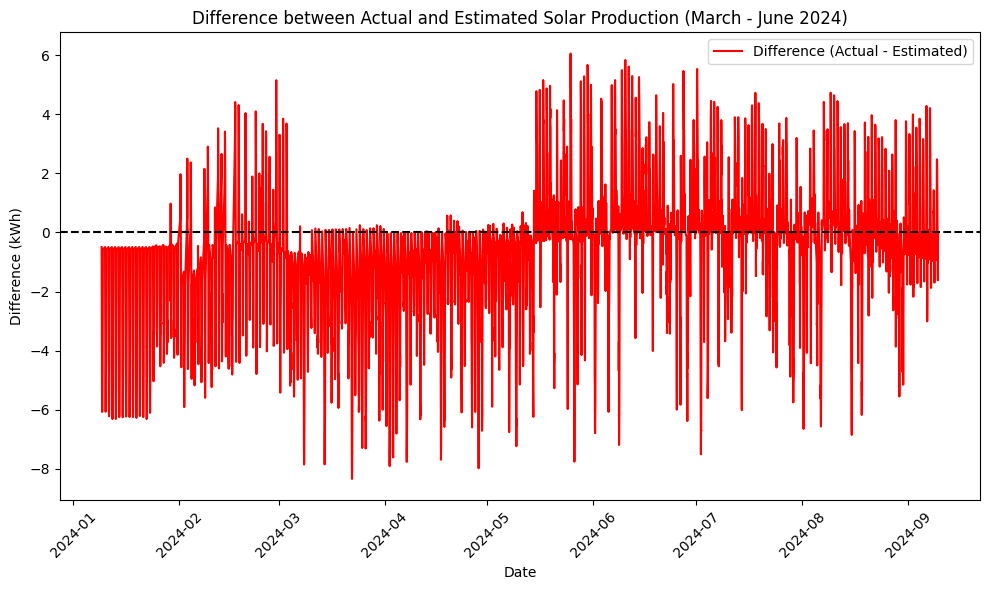

In [28]:
# Filtering the dataframe for March to June 2024
filtered_df['date'] = pd.to_datetime(filtered_df['date'])  # Ensure Date column is in datetime format
march_to_june_df = filtered_df[(filtered_df['date'] >= '2024-01-01') & (filtered_df['date'] <= '2024-10-30')]

filtered_df['Difference'] = filtered_df['value'] - filtered_df['Estimated_Area_Solar_Production']

plt.figure(figsize=(10, 6))
plt.plot(filtered_df['date'], filtered_df['Difference'], label='Difference (Actual - Estimated)', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Difference between Actual and Estimated Solar Production (March - June 2024)')
plt.xlabel('Date')
plt.ylabel('Difference (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


##Daily Aggregation

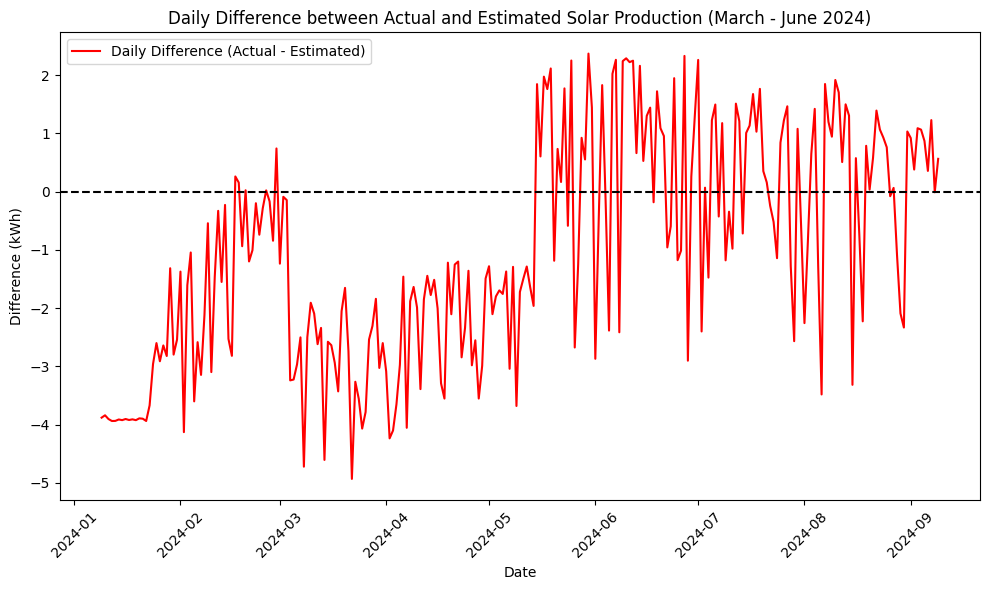

In [29]:
# Filter the dataframe for March to June 2024
march_to_june_df = filtered_df[(filtered_df['date'] >= '2024-01-01') & (filtered_df['date'] <= '2024-10-30')]

# Calculate the difference between actual and estimated production
march_to_june_df['Difference'] = march_to_june_df['value'] - march_to_june_df['Estimated_Area_Solar_Production']

# Aggregate data at the daily level (mean of the hourly data for each day)
daily_diff_df = march_to_june_df.resample('D', on='date').mean()

# Plot the daily difference
plt.figure(figsize=(10, 6))
plt.plot(daily_diff_df.index, daily_diff_df['Difference'], label='Daily Difference (Actual - Estimated)', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Daily Difference between Actual and Estimated Solar Production (March - June 2024)')
plt.xlabel('Date')
plt.ylabel('Difference (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Interpretation of Charts:**

**Chart 1:** Hourly Difference between Actual and Estimated Solar Production
This chart illustrates the difference between the actual (value) and estimated (Estimated_Area_Solar_Production) solar production on an hourly basis from March to June 2024.

**Key Observations:**
**Variance:** The differences show significant variability throughout the period, with values ranging from approximately -8 kWh to +6 kWh.

**Bias Trends:**
There appears to be a systematic bias where the estimates consistently underestimate the actual production in some regions (negative difference) and overestimate in others (positive difference).
The bias grows larger in certain periods (e.g., May and June), potentially reflecting a seasonal or environmental factor.
**Noise: **The hourly resolution captures fine-grained deviations but makes it harder to discern clear trends in bias.

**Chart 2:** Daily Difference between Actual and Estimated Solar Production
This chart aggregates the hourly data into daily averages, providing a smoother representation of the differences over time.

**Key Observations:**
**Trend in Bias:**
There is a notable downward bias in early months (e.g., February and March), where estimates are lower than actual production.
By May and June, the bias shifts upward, with the model overestimating production.
The fluctuations in bias seem to align with seasonal trends.

**Systematic Seasonal Component:**
The overestimation and underestimation may be influenced by environmental factors like cloud cover, solar angle, or seasonal shifts in irradiance.

In [30]:
# Filter the dataframe for March to June 2024
march_to_june_df = filtered_df[(filtered_df['date'] >= '2024-01-01') & (filtered_df['date'] <= '2024-10-30')]

# Calculate the difference between actual and estimated production
march_to_june_df['Difference'] = march_to_june_df['value'] - march_to_june_df['Estimated_Area_Solar_Production']

# -------------------- Hourly RMSE and MAE --------------------

# Calculate Hourly RMSE and MAE
hourly_rmse = np.sqrt((march_to_june_df['Difference'] ** 2).mean())
hourly_mae = march_to_june_df['Difference'].abs().mean()

print(f'Hourly RMSE: {hourly_rmse}')
print(f'Hourly MAE: {hourly_mae}')

# -------------------- Daily RMSE and MAE --------------------

# Aggregate data at the daily level (mean of the hourly data for each day)
daily_diff_df = march_to_june_df.resample('D', on='date').mean()

# Calculate Daily RMSE and MAE
daily_rmse = np.sqrt((daily_diff_df['Difference'] ** 2).mean())
daily_mae = daily_diff_df['Difference'].abs().mean()

print(f'Daily RMSE: {daily_rmse}')
print(f'Daily MAE: {daily_mae}')

# -------------------- Monthly RMSE and MAE --------------------

# Aggregate data at the monthly level (mean of the hourly data for each month)
monthly_diff_df = march_to_june_df.resample('M', on='date').mean()

# Calculate Monthly RMSE and MAE
monthly_rmse = np.sqrt((monthly_diff_df['Difference'] ** 2).mean())
monthly_mae = monthly_diff_df['Difference'].abs().mean()

print(f'Monthly RMSE: {monthly_rmse}')
print(f'Monthly MAE: {monthly_mae}')


Hourly RMSE: 2.7878535770684
Hourly MAE: 2.1004387846291332
Daily RMSE: 2.181465860766583
Daily MAE: 1.8489044552896086
Monthly RMSE: 1.753699218952383
Monthly MAE: 1.300357735373706


/tmp/ipykernel_25298/632397028.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_diff_df = march_to_june_df.resample('M', on='date').mean()


#Exploratory Data Analysis

##Check distribution

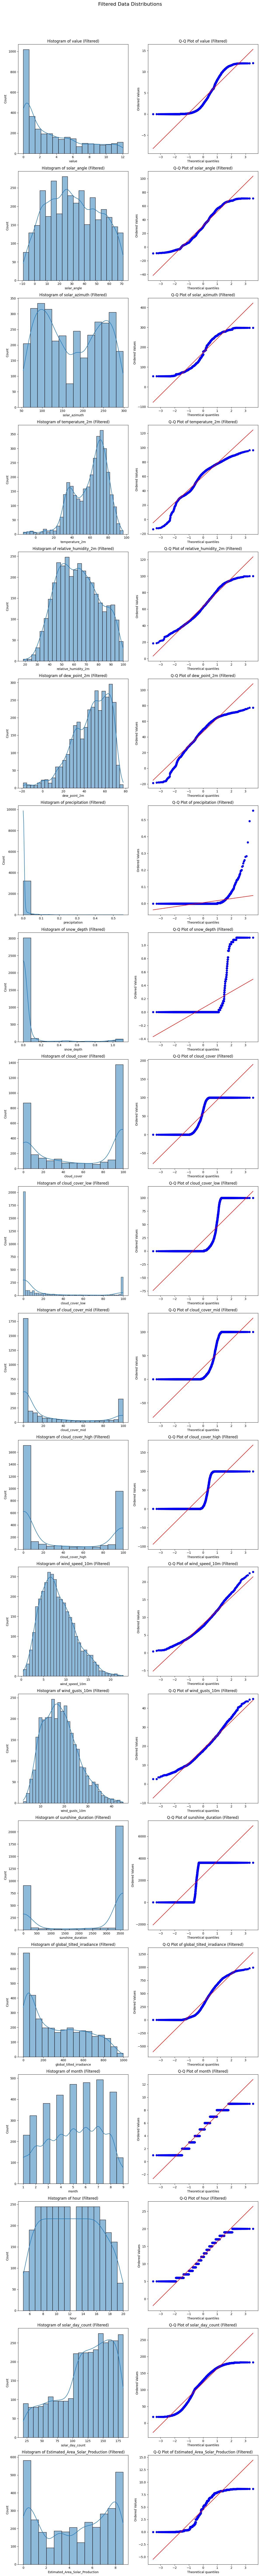

In [31]:
# List of columns to visualize (including the new fields and date components)
columns_to_visualize = ['value','solar_angle',
    'solar_azimuth', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'precipitation', 'snow_depth', 'cloud_cover', 'cloud_cover_low',
    'cloud_cover_mid', 'cloud_cover_high', 'wind_speed_10m',
    'wind_gusts_10m', 'sunshine_duration', 'global_tilted_irradiance', 'month','hour','solar_day_count', 'Estimated_Area_Solar_Production']

# Set up the plotting environment for filtered_df
plt.figure(figsize=(12, len(columns_to_visualize) * 6))
plt.suptitle("Filtered Data Distributions", fontsize=16)

# Loop through each column and create histograms and Q-Q plots for filtered_df
for i, col in enumerate(columns_to_visualize, 1):
    plt.subplot(len(columns_to_visualize), 2, 2*i - 1)
    sns.histplot(filtered_df[col].dropna(), kde=True)
    plt.title(f'Histogram of {col} (Filtered)')

    plt.subplot(len(columns_to_visualize), 2, 2*i)
    stats.probplot(filtered_df[col].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col} (Filtered)')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


**Summary of Distributions:**

**1. Value**
* Histogram: The distribution is highly skewed to the right, indicating a large number of low values for solar production and fewer high values.
* Q-Q Plot: The points deviate significantly from the straight line, suggesting that the distribution is not normal and may contain outliers.

**2. Solar Angle**
* Histogram: The distribution appears roughly symmetric but has multiple peaks, indicating a multimodal distribution.
* Q-Q Plot: The points mostly follow the line but with deviations at the tails, suggesting near-normality but with some deviations.
* Implication: This feature is derived from sun/earth movements and follow consistent cyclical patters that are typically smooth and continuous over time. Due to this and that the data is not present for a full year for model training, no transformation is applied.

**3. Solar Azimuth**
* Histogram: The distribution shows a distinct bimodal pattern.
* Q-Q Plot: The plot shows clear deviations from normality, especially at the tails, confirming the bimodal distribution.
* Implication: This feature is derived from sun/earth movements and follow consistent cyclical patters that are typically smooth and continuous over time. Due to this and that the data is not present for a full year for model training, no transformation is applied.

**4. Temperature**
* Histogram: The distribution is approximately symmetric but with a noticeable peak and some skewness.
* Q-Q Plot: The points follow the line relatively well, with minor deviations at the tails.
* Implication: The near-normal distribution suggests that temperature could work well in a linear model, but the minor skewness might still benefit from transformation.

**5. Humidity**
* Histogram: The distribution is highly skewed to the right with a strong peak at low humidity levels.
* Q-Q Plot: The Q-Q plot shows substantial deviations from normality, particularly in the upper tail.
* Implication: Humidity is highly skewed, suggesting that a tree-based model may handle this feature more effectively. A linear model would likely require transformation to reduce skewness.

**6. Dew Point**
* Histogram: The distribution is fairly symmetric, with a minor skew and a well-defined peak.
* Q-Q Plot: The points are closely aligned with the line, indicating near-normality.
* Implication: Dew Point appears suitable for either model type. Its near-normal distribution makes it amenable to linear models, but it should also work well in tree-based models without requiring transformation.

**7. Precipitation**
* Histogram: The distribution is highly skewed with most values near zero, suggesting many instances of no precipitation.
* Q-Q Plot: The Q-Q plot shows significant deviation, particularly at the lower end, confirming the heavy skew.
* Implication: The high skewness and many zero values suggest that a tree-based model would handle this feature better. A linear model might struggle without transformation or handling the zero-inflation appropriately.

**6. Wind Speed**
* Histogram: The distribution is skewed to the right with a long tail.
* Q-Q Plot: The points deviate significantly from the line, especially in the upper tail, indicating non-normality.
* Implication: The skewness in wind speed suggests that a tree-based model might handle this feature better without transformation. For regression models, applying a transformation (e.g., log) might improve performance.

**9. Cloud Cover**
* Histogram: The distribution is fairly uniform with some peaks, suggesting variability in cloud cover.
* Q-Q Plot: The Q-Q plot shows significant deviations from normality, especially in the tails.
* Implication: The variability in cloud cover and lack of normality suggest that a tree-based model might be more robust in handling this feature. Linear models might need transformations or additional features to model this effectively.

**10. Cloud Cover Low**
* Histogram: The distribution shows a right-skewed pattern with most of the values concentrated at lower cloud cover percentages.
* Q-Q Plot: The points deviate significantly from the line, especially in the upper tail, indicating non-normality and skewness.
* Implication: The skewness in low cloud cover suggests that a tree-based model would handle this feature more effectively, as it does not assume normality. For a regression model, a transformation (e.g., log or square root) might be necessary to handle the skewness.

**11. Cloud Cover Mid**
* Histogram: The distribution is roughly uniform, indicating a wide range of mid-level cloud cover percentages.
* Q-Q Plot: The Q-Q plot shows some deviation from normality, particularly at the tails, reflecting the uniformity.
* Implication: The uniform distribution of mid-level cloud cover suggests that it can be handled well by a tree-based model. For a regression model, the uniform distribution might not require significant transformation but could still benefit from normalization.

**12. Cloud Cover High**
* Histogram: The distribution is highly skewed to the right, with most values concentrated at lower high-level cloud cover percentages.
* Q-Q Plot: The Q-Q plot shows significant deviations from the normal line, especially in the upper tail, indicating non-normality.
* Implication: The skewed nature of high cloud cover is better suited to a tree-based model. In a regression model, applying a transformation to reduce skewness could improve model performance.

**13. Wind Speed at 10m**
* Histogram: The distribution is right-skewed, with most wind speeds concentrated at lower values.
* Q-Q Plot: The points deviate from the line, especially at higher wind speeds, indicating non-normality.
* Implication: The skewness of wind speed at 10m suggests that a tree-based model would naturally handle the distribution without requiring transformation. In contrast, a regression model might benefit from a log transformation to normalize the data.

**14. Wind Gusts at 10m**
* Histogram: The distribution shows a strong right skew with most values clustered at low wind gusts.
* Q-Q Plot: The Q-Q plot reveals significant deviations from normality, particularly at the higher end.
* Implication: The high skewness in wind gusts data suggests that a tree-based model would perform better without transformation. For regression models, a transformation could help normalize the data and improve model fit.

**15. Sunshine Duration**
* Histogram: The distribution is fairly symmetric, with a peak around the mid-range of sunshine duration.
* Q-Q Plot: The Q-Q plot shows minor deviations from the line, suggesting that the data is close to normally distributed.
* Implication: The near-normal distribution of sunshine duration makes it suitable for either model type. A linear regression model could use this feature without much preprocessing, and it would also work well with tree-based models.

**16. Global Tilted Irradiance**
* Histogram: The distribution is skewed to the right, indicating more instances of lower irradiance values.
* Q-Q Plot: The Q-Q plot shows significant deviation from normality, especially in the upper tail.
* Implication: The skewed distribution of global tilted irradiance is better suited for a tree-based model, which can handle such non-linear relationships naturally. For a regression model, applying a transformation (e.g., log) could help in managing the skewness and improve predictive performance.

**17. Month**
* Histogram: The distribution is nearly uniform, as expected for a categorical variable representing months.
* Q-Q Plot: The Q-Q plot shows deviations from normality, reflecting the categorical nature of the data.
* Implication: No transformation will be applied currently due to the incomplete representation for the full year.

**18. Hour**
* Histogram: The distribution shows a cyclical pattern, with distinct peaks likely corresponding to times of day when solar production is highest.
* Q-Q Plot: The Q-Q plot shows deviations from normality, particularly at the extremes, consistent with the cyclical nature of the data.
* Implication: The hour is an important cyclical feature that tree-based models can handle effectively without preprocessing. For regression models, encoding this feature using sine and cosine transformations would capture its cyclical nature and improve model performance.

**Summary Implications for Model Choice:**
Tree-Based Models: Generally, tree-based models (e.g., Decision Trees, Random Forests, Gradient Boosting) are likely to perform well on this dataset as they can handle skewed distributions, outliers, and non-linear relationships without requiring much preprocessing.

Regression Models: If considering linear regression, several features would need transformations (log, square root, etc.) to reduce skewness and improve normality. Interaction terms might also be necessary to handle multimodal distributions effectively.


**Action Items and Feature Engineering Insights:**

**Account for Seasonal Trends:**

Add seasonal features like month, solar_day_count, and interaction terms (e.g., solar_angle * cloud_cover) to capture these temporal patterns.

**Bias Correction:**

Consider creating a bias adjustment feature based on the observed trends in the differences. For example:
Include separate correction terms for months or time periods with consistent over- or underestimation.

**Explore Weather Features:**

The discrepancies may highlight the need for better representation of weather factors like cloud cover (high, mid, low levels), precipitation, and temperature.

**Temporal Aggregation:**

While the hourly data captures short-term variations, models might benefit from daily aggregation to reduce noise and better capture longer-term trends.

#Handle the 0 Values in the target
- In order to use Mean Absolute Percentage Error (MAPE) as an optimization metric, replace zero values with a small constant to avoid division by zero.

In [32]:
# Assuming filtered_df is your DataFrame and 'value' is the target column

# Step 1: Replace zero values in the 'value' column with a small constant
filtered_df['value'] = filtered_df['value'].replace(0, 1e-10)

# Verify that zero values have been replaced
print(filtered_df['value'].describe())

# Now you can proceed with using MAPE as the optimization metric in XGBoost


count    3.357000e+03
mean     3.577321e+00
std      3.579236e+00
min      1.000000e-10
25%      4.750000e-01
50%      2.317000e+00
75%      5.855000e+00
max      1.205300e+01
Name: value, dtype: float64


#Finalize Data

In [33]:
# Drop the 'Difference' column as it's not needed
hourly_df = filtered_df.drop(columns=['Difference'])



In [34]:
hourly_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             3357 non-null   datetime64[ns]
 1   month                            3357 non-null   int32         
 2   day_of_month                     3357 non-null   int32         
 3   hour                             3357 non-null   int32         
 4   is_daylight                      3357 non-null   int64         
 5   solar_angle                      3357 non-null   float64       
 6   solar_azimuth                    3357 non-null   float64       
 7   temperature_2m                   3357 non-null   float32       
 8   relative_humidity_2m             3357 non-null   float32       
 9   dew_point_2m                     3357 non-null   float32       
 10  precipitation                    3357 non-null   float32    

#Train/Test Split

In [35]:
# Ensure 'ds' column is in datetime format
hourly_df['date'] = pd.to_datetime(hourly_df['date'])

# Sort the data by date
hourly_df = hourly_df.sort_values(by='date')

# Define the date ranges for training and testing
train_start_date = '2024-01-08'
train_end_date = '2024-06-08'
test_start_date = '2024-06-09'
test_end_date = '2024-09-18'

# Step 1: Filter the data based on the date range for the training set
train_df = hourly_df[(hourly_df['date'] >= train_start_date) & (hourly_df['date'] <= train_end_date)]

# Step 2: Filter the data based on the date range for the test set
test_df = hourly_df[(hourly_df['date'] >= test_start_date) & (hourly_df['date'] <= test_end_date)]

# Check the sizes of each dataset
print(f"Train set size: {len(train_df)} rows")
print(f"Test set size: {len(test_df)} rows")

# Display the first few rows of each DataFrame to verify
print("Train set sample:")
print(train_df.head())

print("\nTest set sample:")
print(test_df.head())


Train set size: 1937 rows
Test set size: 1404 rows
Train set sample:
                 date  month  day_of_month  hour  is_daylight  solar_angle  \
0 2024-01-09 07:00:00      1             9     7            1    -4.132298   
1 2024-01-09 08:00:00      1             9     8            1     5.410634   
2 2024-01-09 09:00:00      1             9     9            1    13.549794   
3 2024-01-09 10:00:00      1             9    10            1    20.018658   
4 2024-01-09 11:00:00      1             9    11            1    24.211071   

   solar_azimuth  temperature_2m  relative_humidity_2m  dew_point_2m  ...  \
0     116.331676       27.019400             86.426872     23.509399  ...   
1     126.501911       30.079399             82.816345     25.489399  ...   
2     137.851109       32.329399             82.365807     27.559401  ...   
3     150.681468       33.589401             72.969177     25.849400  ...   
4     164.975777       34.219398             70.891037     25.759399  ...   


In [36]:
train_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1937 entries, 0 to 1936
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             1937 non-null   datetime64[ns]
 1   month                            1937 non-null   int32         
 2   day_of_month                     1937 non-null   int32         
 3   hour                             1937 non-null   int32         
 4   is_daylight                      1937 non-null   int64         
 5   solar_angle                      1937 non-null   float64       
 6   solar_azimuth                    1937 non-null   float64       
 7   temperature_2m                   1937 non-null   float32       
 8   relative_humidity_2m             1937 non-null   float32       
 9   dew_point_2m                     1937 non-null   float32       
 10  precipitation                    1937 non-null   float32       
 

#Check Distributions between train and test

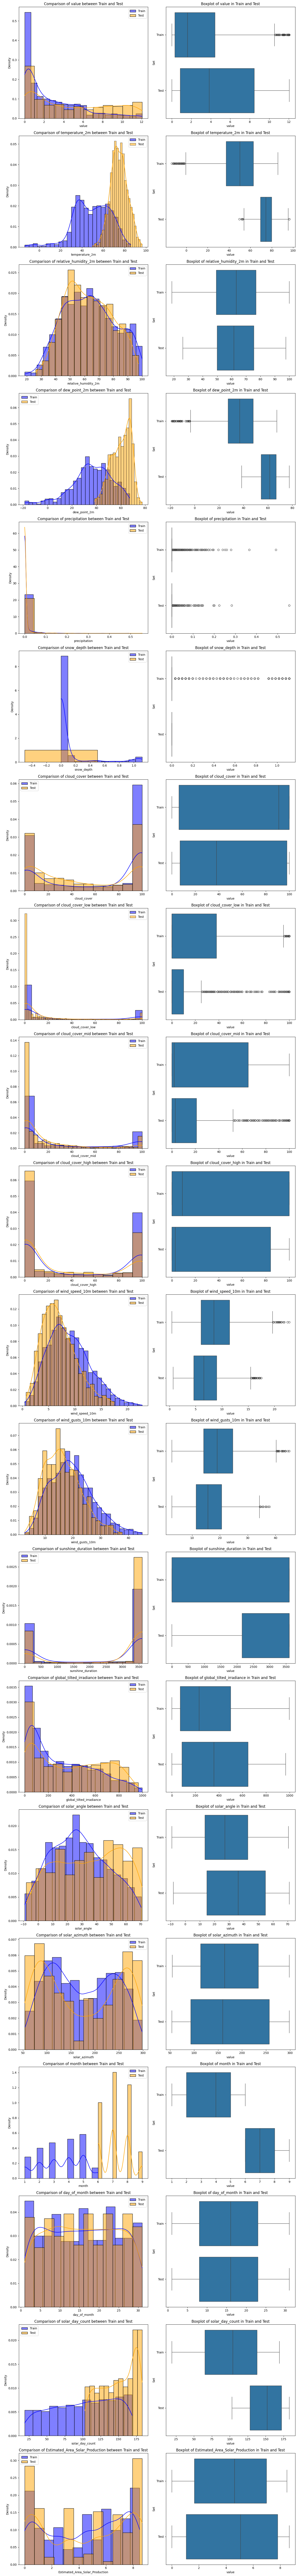

              Train                                                   \
              value temperature_2m relative_humidity_2m dew_point_2m   
count  1.937000e+03    1937.000000          1937.000000  1937.000000   
mean   2.715249e+00      49.217525            63.645931    36.330936   
std    2.956639e+00      17.170931            17.933722    16.484062   
min    1.000000e-10     -13.660603            18.477701   -18.700600   
25%    3.050000e-01      37.279400            49.375439    27.289400   
50%    1.612000e+00      50.059399            63.187290    36.919399   
75%    4.417000e+00      62.749401            76.827629    47.899399   
max    1.204100e+01      85.609398           100.000000    67.249405   

                                                                               \
      precipitation   snow_depth  cloud_cover cloud_cover_low cloud_cover_mid   
count   1937.000000  1937.000000  1937.000000     1937.000000     1937.000000   
mean       0.006380     0.107148    

In [37]:
# List of columns to analyze
columns_to_analyze = ['value', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
                      'precipitation', 'snow_depth', 'cloud_cover',
                      'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
                      'wind_speed_10m', 'wind_gusts_10m',  'sunshine_duration',
                      'global_tilted_irradiance', 'solar_angle', 'solar_azimuth',
                      'month', 'day_of_month', 'solar_day_count', 'Estimated_Area_Solar_Production']

# Set up the plotting environment
plt.figure(figsize=(14, len(columns_to_analyze) * 6))

# Loop through each column and compare distributions
for i, col in enumerate(columns_to_analyze, 1):
    plt.subplot(len(columns_to_analyze), 2, 2*i - 1)
    sns.histplot(train_df[col].dropna(), kde=True, color='blue', label='Train', stat='density')
    sns.histplot(test_df[col].dropna(), kde=True, color='orange', label='Test', stat='density')
    plt.legend()
    plt.title(f'Comparison of {col} between Train and Test')

    plt.subplot(len(columns_to_analyze), 2, 2*i)
    # Stack the data and create a DataFrame for boxplot
    boxplot_data = pd.DataFrame({
        'value': pd.concat([train_df[col], test_df[col]]),
        'Set': ['Train'] * len(train_df[col]) + ['Test'] * len(test_df[col])
    })
    sns.boxplot(x='value', y='Set', data=boxplot_data, orient='h')
    plt.title(f'Boxplot of {col} in Train and Test')

plt.tight_layout()
plt.show()

# Descriptive Statistics Comparison
descriptive_stats_train = train_df[columns_to_analyze].describe()
descriptive_stats_test = test_df[columns_to_analyze].describe()

# Concatenate the two sets of descriptive statistics for easier comparison
descriptive_stats_comparison = pd.concat([descriptive_stats_train, descriptive_stats_test], axis=1, keys=['Train', 'Test'])

print(descriptive_stats_comparison)


#Pickle Train, Test

In [39]:
import os
# Define file paths for GitHub storage
train_df_path = "train_df.pkl"
test_df_path = "test_df.pkl"

# Save DataFrames locally
train_df.to_pickle(train_df_path)
print(f"✅ train_df has been saved to {train_df_path}")

test_df.to_pickle(test_df_path)
print(f"✅ test_df has been saved to {test_df_path}")

# Push the files to GitHub
os.system(f"git add {train_df_path} {test_df_path}")
os.system('git commit -m "Saved train and test DataFrames"')
os.system("git push origin main")

print("🚀 train_df and test_df pushed to GitHub!")


✅ train_df has been saved to train_df.pkl
✅ test_df has been saved to test_df.pkl
[main 96c0f9d] Saved train and test DataFrames
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 test_df.pkl
 create mode 100644 train_df.pkl


🚀 train_df and test_df pushed to GitHub!


To https://github.com/AmyHumke12/SolarProject
   b0adec1..96c0f9d  main -> main


**Summary of Train/Test Differences (Daily Level)**

**Value:**

The test set has a higher mean and a more concentrated distribution toward the upper end of the range (above 50), while the train set has a wider spread with a significant proportion of values below 40.
Outliers are present in the train set at the higher end but are more balanced in the test set.

**Temperature (2m):**

Both datasets show similar distributions, but the test set has a slightly higher concentration between 60 and 70 degrees, whereas the train set has a broader spread with values below 40.
The train set exhibits a few outliers at very low temperatures (-8 to 0).
Relative Humidity (2m):

The test set distribution is more peaked and centered between 60–80%, while the train set has a broader range extending below 50%.
Overall, the variability in the test set is slightly less than in the train set.
Dew Point (2m):

The test set shows a higher mean and tighter spread around 40–60 compared to the train set, which has a broader distribution, including values below 20.
Outliers are present in the train set at very low dew points.
Precipitation:

Both train and test sets exhibit highly skewed distributions with most values near 0, but the train set includes heavier outliers (precipitation > 1.0).
The test set generally shows less variability in precipitation levels.
Snow Depth:

Snow depth is negligible in both train and test sets, with most values near 0.
The train set includes a few outliers around 1.0, which are not present in the test set.
Cloud Cover:

Cloud cover in the test set is concentrated in the lower range (below 40%), while the train set has a broader spread, including high cloud cover values above 80%.
Median cloud cover is significantly lower in the test set.
Cloud Cover (Low, Mid, High):

All three cloud cover variables follow the same trend: the test set has a lower concentration of mid and high cloud cover values, while the train set exhibits a wider distribution.
The test set has smaller interquartile ranges across these variables.
Wind Speed (10m):

Wind speeds in the test set are generally lower, with most values concentrated between 4–8 m/s, while the train set includes higher speeds up to 14 m/s.
The boxplot indicates that the variability is higher in the train set.
Wind Gusts (10m):

The test set has a tighter distribution of wind gusts (10–20 m/s), while the train set includes higher values (up to 35 m/s).
Variability is greater in the train set, and outliers are more prevalent.
Sunshine Duration:

The test set exhibits higher average sunshine durations (peaking near 50,000 seconds), whereas the train set has more variability with durations spread across a broader range.
Outliers in the train set appear at very low sunshine durations (< 10,000 seconds).
Global Tilted Irradiance:

Similar to sunshine duration, the test set shows a tighter concentration between 350–450, whereas the train set has a broader distribution and includes values below 200.
The median value is higher in the test set.
Solar Angle:

The solar angle distribution in the test set is tightly centered between 33–37 degrees, whereas the train set includes lower angles (15–25 degrees).
This difference reflects seasonal variation between the two sets.
Solar Azimuth:

Solar azimuth values are closely centered around 172–175 in the test set, with almost no variability compared to the broader spread in the train set (164–175).
This indicates a difference in solar orientation due to time of year.
Month:

The train set includes months from January to June, while the test set covers July to September, reflecting clear seasonal differences between the two splits.
Day of Month:

Both train and test sets are evenly distributed across days, with no significant differences in variability.
Solar Day Count:

The solar day count is lower in the train set (average ~75 days) and higher in the test set (average ~150 days), reflecting the progression of the solar production season.
Estimated Area Solar Production:

The estimated production values in the test set are more concentrated around 65–70, while the train set includes a broader range with values as low as 40.

**Key Takeaways**
The train and test sets differ significantly in key variables, including solar angle, global tilted irradiance, cloud cover, and temperature, largely due to seasonal differences.
The test set generally exhibits tighter distributions and less variability than the train set, reflecting a more stable period (summer months).
Differences in variables like wind speed, solar angle, and cloud cover could influence the model's ability to generalize from the train set to the test set.